## Agents

## Scenario overview

In this lab we are going to create an Agent that will have access to tools to find a vacation destination. You will be able to ask this agent questions, watch it call the required tools, and have conversations with it. The lab will cover the following scenario:

The agent we will build is a travel chatbot assisting in finding the next best travel destination. Therefor, we will create an agent capable of finding vacation destinations based on user's profile and travel history of similar users. This agent will have access to tool that can search based on available travel history data. Further, this agent will have access to retriever tool that can provide further details to different cities in the United States.

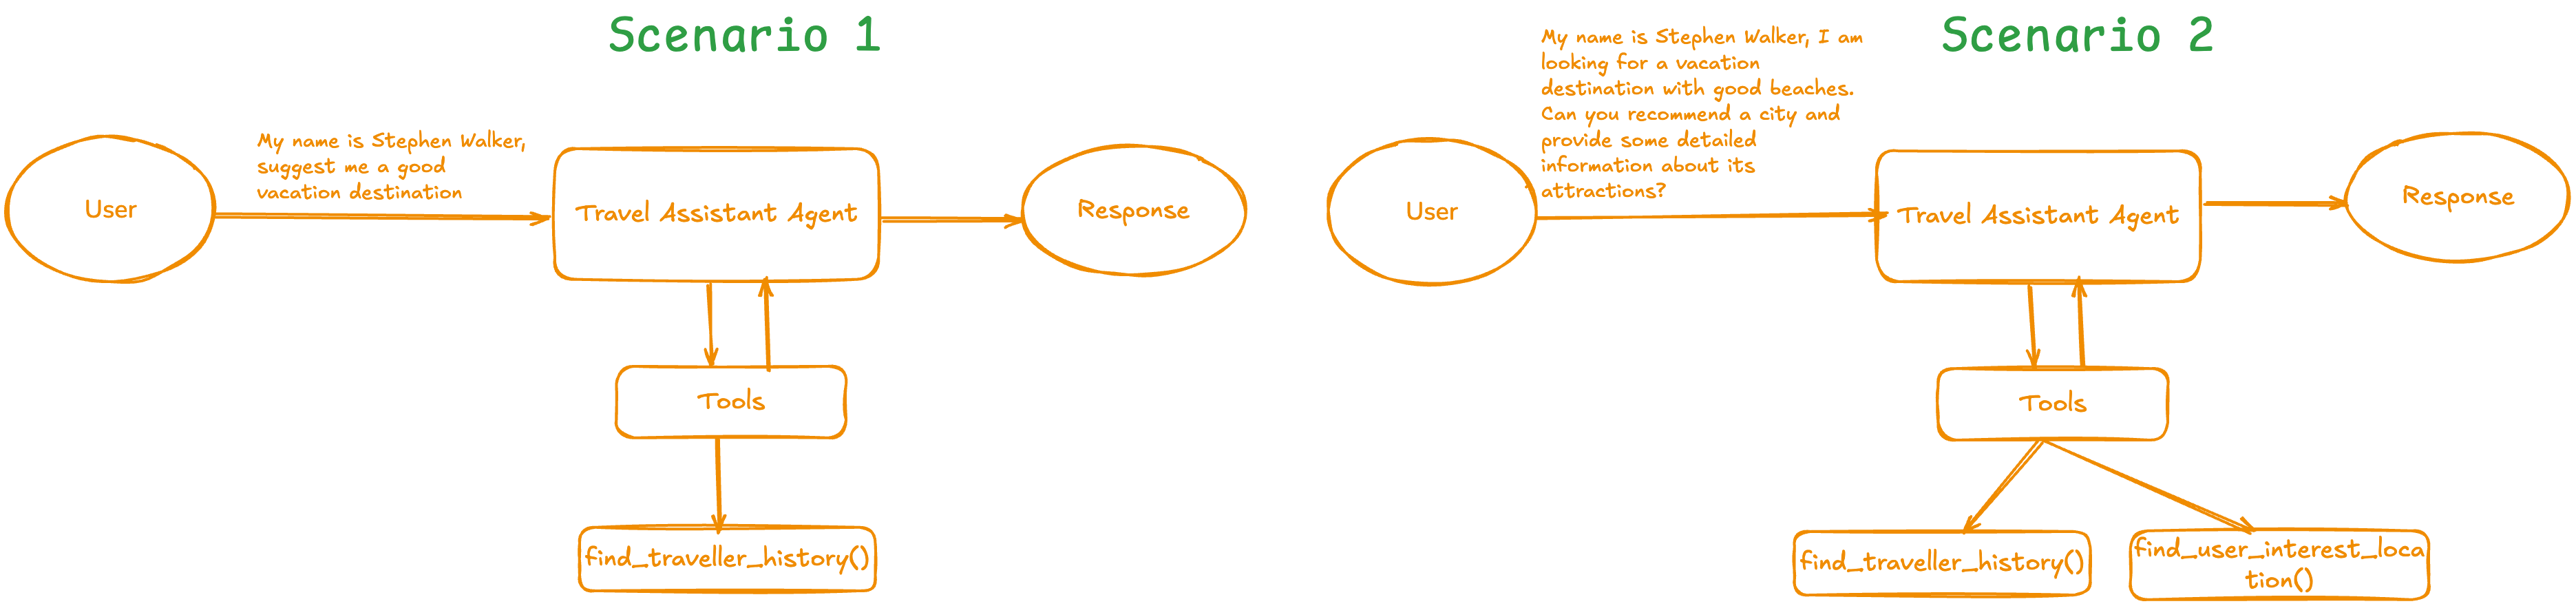

## Setup

Let's start with installing required packages. 

In [ ]:
%pip install -U --no-cache-dir  \
"langchain==0.3.7" \
"langchain-aws==0.2.6" \
"langchain-community==0.3.5" \
"langchain-text-splitters==0.3.2" \
"langchainhub==0.1.20" \
"langgraph==0.2.45" \
"langgraph-checkpoint==2.0.2" \
"langgraph-sdk==0.1.35" \
"langsmith==0.1.140" \
"pypdf==3.8,<4" \
"ipywidgets>=7,<8" \
"matplotlib==3.9.0"

We create a Bedrock client that is used to configure LLM in LangChain to use Bedrock.

In [4]:
from langchain_aws import ChatBedrock
import boto3

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")

## Language Model

The LLM powering all of our agent implementations in this lab will be Claude 3 Sonnet via Amazon Bedrock. For easy access to the model we are going to use `ChatBedrockConverse` class of LangChain, which is a wrapper around Bedrock's Converse API. 

In [5]:
from langchain_aws import ChatBedrockConverse

llm = ChatBedrockConverse(
    # model="anthropic.claude-3-sonnet-20240229-v1:0",
    model = "anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

# Build a first travel recommendation agent 

## Tools

Let's create tools that will be used by our agents to find a vacation destination based on user' profile and travel history of similar users.

Tools are external resources, services, or APIs that an LLM agent can access and utilize to expand its capabilities and perform specific tasks. These supplementary components allow the agent to go beyond its core language processing abilities, enabling it to interact with external systems, retrieve information, or execute actions that would otherwise be outside its scope. By integrating tools, LLM agents can provide more comprehensive and practical solutions to user queries and commands.

We will create a tool that uses historic travel information of different users to find a vacation destination based on user' profile and travel history of similar users. The tool will use the local csv file to retrieve historical data about travel destinations. It will then analyze the data and return the most popular destination for the user.



We will use LangChain Tools to create tools that are used by our agents. These are utilities designed to be called by a model: their inputs are designed to be generated by models, and their outputs are designed to be passed back to models. Tools are needed whenever you want a model to control parts of your code or call out to external APIs.

A tool consists of:

- The name of the tool.
- A description of what the tool does.
- A JSON schema defining the inputs to the tool.
- A function (and, optionally, an async variant of the function)

Tools can be specified by decorating them with the ```@tool``` decorator. This parses the respective function name as well as docstrings and input parameters into a name, description and interface definition. When a tool is bound to a model, this information is provided as context to the model. Given a list of tools and a set of instructions, a model can figure out how to call one or more tools with specific inputs as well as when to call which tool. 

In [6]:
import pandas as pd
from collections import Counter
from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig


def read_travel_data(file_path: str = "data/synthetic_travel_data.csv") -> pd.DataFrame:
    """Read travel data from CSV file"""
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        return pd.DataFrame(
            columns=[
                "Id",
                "Name",
                "Current_Location",
                "Age",
                "Past_Travel_Destinations",
                "Number_of_Trips",
                "Flight_Number",
                "Departure_City",
                "Arrival_City",
                "Flight_Date",
            ]
        )


@tool
def compare_and_recommend_destination(config: RunnableConfig) -> str:
    """This tool is used to check which destinations user has already traveled.
    Use name of the user to fetch the information about that user.
    If user has already been to a city then do not recommend that city.

    Returns:
        str: Destination to be recommended.

    """

    df = read_travel_data()
    user_id = config.get("configurable", {}).get("user_id")

    if user_id not in df["Id"].values:
        return "User not found in the travel database."

    user_data = df[df["Id"] == user_id].iloc[0]
    current_location = user_data["Current_Location"]
    age = user_data["Age"]
    past_destinations = user_data["Past_Travel_Destinations"].split(", ")

    # Get all past destinations of users with similar age (±5 years) and same current location
    similar_users = df[
        (df["Current_Location"] == current_location)
        & (df["Age"].between(age - 5, age + 5))
    ]
    all_destinations = [
        dest
        for user_dests in similar_users["Past_Travel_Destinations"].str.split(", ")
        for dest in user_dests
    ]

    # Count occurrences of each destination
    destination_counts = Counter(all_destinations)

    # Remove user's current location and past destinations from recommendations
    for dest in [current_location] + past_destinations:
        if dest in destination_counts:
            del destination_counts[dest]

    if not destination_counts:
        return f"No new recommendations found for users in {current_location} with similar age."

    # Get the most common destination
    recommended_destination = destination_counts.most_common(1)[0][0]

    return f"Based on your current location ({current_location}), age ({age}), and past travel data, we recommend visiting {recommended_destination}."

The second tool we want to add to our travel recommendation agent is a retrieval tool. The retrieval tool will allow the agent to access and utilize external information, enhancing its knowledge base. We have synthetic data about few cities in the world. We'll use this data to populate our knowledge base with additional information about each city.

In this section, we prepare our retriever:

1. We use PyPDFDirectoryLoader to load PDF documents from a specified directory.
2. The loaded documents are split into smaller chunks using RecursiveCharacterTextSplitter for more effective processing.
3. We initialize the BedrockEmbeddings model to create embeddings of our text chunks.
4. A Chroma vector store is created from the document splits using the embeddings.
5. Finally, we set up a retriever from the vector store, which will allow our chatbot to fetch relevant information based on user queries.


In [7]:
from langchain_community.document_loaders import PyPDFDirectoryLoader

loader = PyPDFDirectoryLoader("data/us")
docs = loader.load()
docs[0]

Document(metadata={'source': 'data/us/oklahoma_city_travel_guide.pdf', 'page': 0}, page_content="Travel Guide: Oklahoma City\nGenerated by Llama3.1 405B\n \nOklahoma City: Where the West Meets the East\n \nNestled in the heart of the Great Plains, Oklahoma City is a vibrant metropolis that seamlessly blends\nits frontier heritage with modern sophistication. As the capital and largest city of Oklahoma, this\ndynamic destination offers visitors a unique glimpse into the state's rich history and thriving cultural\nscene.\n \nAt the iconic Bricktown Entertainment District, you can stroll along the picturesque Bricktown Canal,\nexplore the lively bars and restaurants, or catch a baseball game at the Chickasaw Bricktown Ballpark.\nThe National Cowboy & Western Heritage Museum is a must-visit, showcasing the region's ranching\nlegacy through impressive art collections and interactive exhibits. For a taste of the city's Native\nAmerican roots, the American Indian Cultural Center and Museum pro

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_aws.embeddings.bedrock import BedrockEmbeddings

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)


embeddings_model = BedrockEmbeddings(
    client=bedrock_client, model_id="amazon.titan-embed-text-v1"
)
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings_model)
retriever = vectorstore.as_retriever()

We now create a specialized retrieval tool using the `create_retriever_tool` function from LangChain:

1. The tool is based on our previously set up retriever.
2. We name it "search_user_interest".
3. Its description specifies that it searches through multiple PDF documents containing city details.
4. The tool is designed to find information that matches the user's interests in various cities.
5. It's instructed to search based only on the keywords mentioned in the user's input.


In [9]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "search_user_interest",
    "Searches through multiple PDF documents containing city details to find information matching the user's interests in various cities. Only search based on the keyword mentioned in user input.",
)

Now we also add both tools to the list of tools our agent will be able to use.

In [10]:
tools = [compare_and_recommend_destination, retriever_tool]

## Create Agent

Now that we have defined the tools and the LLM, we can create the agent. LangGraph comes with pre-built higher level APIs for comment agent scenarios. These higher level APIs cover a lot of the heavy lifting when constructing our StateGraph for common agent use cases. For scenario 1 we will be using such a high level API to construct the agent and it's StateGraph. Later in Scenario 2 we will use lower level APIs and rebuild what the higher level API is doing under the hood. 

Let's start with initializing the agent with the LLM and the tools.

In [13]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools)
type(agent_executor)

langgraph.graph.state.CompiledStateGraph

The ```create_react_agent```funtion returned a ```CompiledStateGraph``` object. Let's visualize this graph.

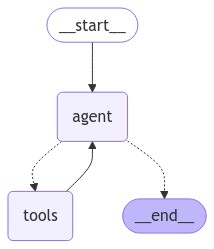

In [11]:
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

We are ready to test our agent with a sample input!

In [12]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"user_id": 918}}

response = agent_executor.invoke(
    {
        "messages": [
            HumanMessage(
                content="Suggest me a good vacation destination."
            )
        ]
    },
    config
)
print("--------")
print("Full trace:")
print(response["messages"])
print("--------")
print("Final response:")
print(response["messages"][-1].content)
print("--------")

--------
Full trace:
[HumanMessage(content='Suggest me a good vacation destination.', additional_kwargs={}, response_metadata={}, id='e768f466-425e-434a-8648-b8f5b46bdc97'), AIMessage(content="Okay, let's try to find a good vacation destination for you. To do that, I'll first need to know a bit more about your interests and travel history. Could you please provide me with your name so I can check which destinations you've already visited? That way I can recommend somewhere new that might be a good fit.", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '261a34f7-0bfe-4447-823a-b809ba5b4456', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 11 Nov 2024 12:52:44 GMT', 'content-type': 'application/json', 'content-length': '498', 'connection': 'keep-alive', 'x-amzn-requestid': '261a34f7-0bfe-4447-823a-b809ba5b4456'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': 1137}}, id='run-0e009aaf-622d-4c43-98b2-d83358c9db62-0', usage_metadata={

The agent if first calling the ```compare_and_recommend_destination``` tool to recommend a destination. Then, it is calling the ```search_user_interest``` tool to figure out more information about the suggested destination through RAG so it can provide an answer with grounded facts.

The complete chronology of actions behind the scene is as follows: 

1. User asks for a travel vacation recommendation
2. The LLM uses compare_and_recommend_destination tool to analyze user's profile (location, age, and past travel data) and suggests a location
3. The LLM then uses search_user_interest tool to gather more information about the location
4. Based on the search results, the LLM provides a detailed response, highlighting the location's attractions, which are extracted of the pdf documents that are used to create retriever.

## Memory

Above agent does not remeber previous conversations. We can add memory to our agent by passing checkpointer. When passing in a checkpointer, we also have to pass in a `thread_id` when invoking the agent (so it knows which thread/conversation to resume from).

In [11]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [14]:
agent_executor = create_react_agent(llm, tools, checkpointer=memory)

config = {"configurable": {"thread_id": "1", "user_id": 918}}

In [15]:
print(
    agent_executor.invoke(
        {
            "messages": [
                (
                    "user",
                    "Suggest me a good vacation destination.",
                )
            ]
        },
        config,
    )["messages"][-1].content
)
print("--------")
print(
    agent_executor.invoke(
        {
            "messages": [
                ("user", "Give me more information about the location you suggested")
            ]
        },
        config,
    )["messages"][-1].content
)
print("--------")

Ljubljana is the capital and largest city of Slovenia. It's known for its well-preserved Baroque and Renaissance architecture, lively cultural scene, and beautiful natural surroundings. Some key highlights include:

- The historic old town center along the Ljubljanica River, with its medieval castle, bridges, and charming cafes
- Tivoli Park, a large urban green space perfect for walking, cycling, and relaxing
- The Ljubljana Central Market, a lively open-air market selling local produce, crafts, and street food
- Numerous museums, galleries, and performing arts venues showcasing Slovenian culture

Ljubljana has a relatively mild climate and is a great destination to visit year-round. It's also well-connected to other popular destinations in Europe, making it a convenient base for further exploration.

Does this sound like a good fit for your interests and travel preferences? Let me know if you would like me to look into any other potential destinations.
--------
I'm still not finding 

# Enhance configurability through use of lower level APIs: Build a ReAct agent from scratch

So far we have seen that LLM is able to decide which tool it has to use. The language model also understands how to combine tools and provide a good response. We have used `create_react_agent` class of LangGraph, which has simplified things for us. 

**But what if we need more control to move from one node to other. What if tool does not have all the inputs to execute the function?  What if we want to directly return the output ut of the tool?**

In this section, we'll explore how to create a more customized and transparent agent using LangGraph. While the `create_react_agent` class provided a convenient high-level interface, we'll now dive deeper to gain more control over the agent's decision-making process and tool usage.

## Agent State

The graph we will be building further down is parameterized by a state object that is passed around to each node during graph execution for keeping the state. Each node updates this state during invocation.

In this example we want each node to add messages to the message list. Therefore, we define a TypedDict with one key (messages) as State. To accumulate the message history we specify the add_messages operator for updates. 

In [16]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, MessagesState
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

## Agent¶
Next, define the assistant function. This function takes the graph state, formats it into a prompt, and then calls an LLM for it to predict the best response.

In [17]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant capable of providing travel recommendations."
            " Use the provided tools to look for personalized travel recommendations and information about specific destinations."
            " `compare_and_recommend_destination` has information about user. Use this tool to get recommendation"
            " If you dont have enough information then use AskHuman tool to get required information. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up.",
        ),
        ("placeholder", "{messages}"),
    ]
)


llm = ChatBedrockConverse(
    # model="anthropic.claude-3-sonnet-20240229-v1:0",
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

runnable_with_tools = primary_assistant_prompt | llm.bind_tools(tools)

def call_model(state: State, config: RunnableConfig):
    response = runnable_with_tools.invoke(state)
    return {"messages": [response]}

## State Graph, Nodes and Edges

First, we are initializing the ```StateGraph```. This object will encapsulate the graph being traversed during excecution.

Then we define the **nodes** in our graph. In LangGraph, nodes are typically python functions. There are two main nodes we will use for our graph:
- The agent node: responsible for deciding what (if any) actions to take.
- The tool node: This node will orchestrate calling the respective tool and returning the output. This means if the agent decides to take an action, this node will then execute that action.

**Edges** define how the logic is routed and how the graph decides to stop. This is a big part of how your agents work and how different nodes communicate with each other. There are a few key types of edges:

- Normal Edges: Go directly from one node to the next.
- Conditional Edges: Call a function to determine which node(s) to go to next.
- Entry Point: Which node to call first when user input arrives.
- Conditional Entry Point: Call a function to determine which node(s) to call first when user input arrives.

In our case we need to define a conditional edge that routes to the ```ToolNode``` when a tool get called in the agent node, i.e. when the LLM determines the requirement of tool use. With ```tools_condition```, LangGraph provides a preimplemented function handling this. Further, an edge from the ```START```node to the ```assistant```and from the ```ToolNode``` back to the ```assistant``` are required.

We are adding the nodes, edges as well as a persistant memory to the ```StateGraph``` before we compile it. 

In [19]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)


# Define nodes: these do the work
graph_builder.add_node("travel_planner", call_model)
graph_builder.add_node("tools", ToolNode(tools=tools))  
# Define edges: these determine how the control flow moves
graph_builder.add_edge(START, "travel_planner")
graph_builder.add_conditional_edges(
    "travel_planner",
    tools_condition,
)
graph_builder.add_edge("tools", "travel_planner")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
travel_planner_agent = graph_builder.compile(checkpointer=memory)

Let's take a look into a visual representation of our compiled state graph.

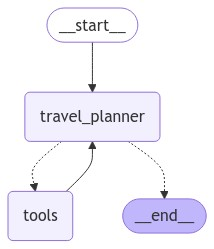

In [20]:
from IPython.display import Image, display

display(Image(travel_planner_agent.get_graph().draw_mermaid_png()))

Its time to test our compiled graph. We can use the input the we have used before

> My name is Stephen Walker, suggest me a good vacation destination.

In [21]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "4", "user_id": 709}}

input_message = HumanMessage(
    content="Suggest me a good vacation destination."
)
for event in travel_planner_agent.stream(
    {"messages": [input_message]}, config, stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Suggest me a good vacation destination.
================================== Ai Message ==================================

[{'type': 'text', 'text': "Okay, let's try to find a good vacation destination for you. "}, {'type': 'tool_use', 'name': 'compare_and_recommend_destination', 'input': {'user_name': 'user'}, 'id': 'tooluse_Jduws79kS5ive5jpdefEEg'}]
Tool Calls:
  compare_and_recommend_destination (tooluse_Jduws79kS5ive5jpdefEEg)
 Call ID: tooluse_Jduws79kS5ive5jpdefEEg
  Args:
    user_name: user
================================= Tool Message =================================
Name: compare_and_recommend_destination

No new recommendations found for users in Sacramento with similar age.
================================== Ai Message ==================================

It looks like I don't have enough information about your travel history and interests to recommend a specific destination. Could you please 

# Interactive agentic flows with return of control: interact with a user during execution time for additional inputs

Sometimes, additional input might be required to execute a tool or to solve a higher level task. In this case, we need to return control back to the user to collect human feedback. 
In LangGraph this can be implemented through a breakpoint-like concept: we stop graph execution at a specific step. At this breakpoint, we can wait for human input. Once we have input from the user, we can add it to the graph state and proceed. In what follows, we will extend our agentic assistant to support user interaction through return of control.

### Interrupt for approval

We're building a system that handles various hotel management operations like suggesting hotels, retrieving bookings, modifying reservations, and processing cancellations. A key requirement is to implement human approval for sensitive operations (changes and cancellations) while allowing other operations to proceed automatically. This creates a natural division in our workflow between operations that can proceed automatically and those requiring human oversight.

We can have two approaches to implementing this:

| Approach | Description | Pros | Cons |
|----------|-------------|------|------|
| **Prompt Approach with ask_human node** | Single flow where human approval is handled through prompt engineering. System determines approval needs based on operation type within prompt. |  More streamlined graph structure with fewer nodes |  Higher risk of prompt misinterpretation |
| | |  More flexible to add/remove human approval requirements without changing graph structure |  Could be more challenging to debug prompt-related issues |
| **Separated Node Approach** | Separates workflow into two distinct paths - one for routine operations and another for sensitive operations requiring approval. |  Deterministic workflow in the graph |  More state management overhead |
| | |  Clear separation of concerns between safe and approval-requiring operations |  More complex graph structure |


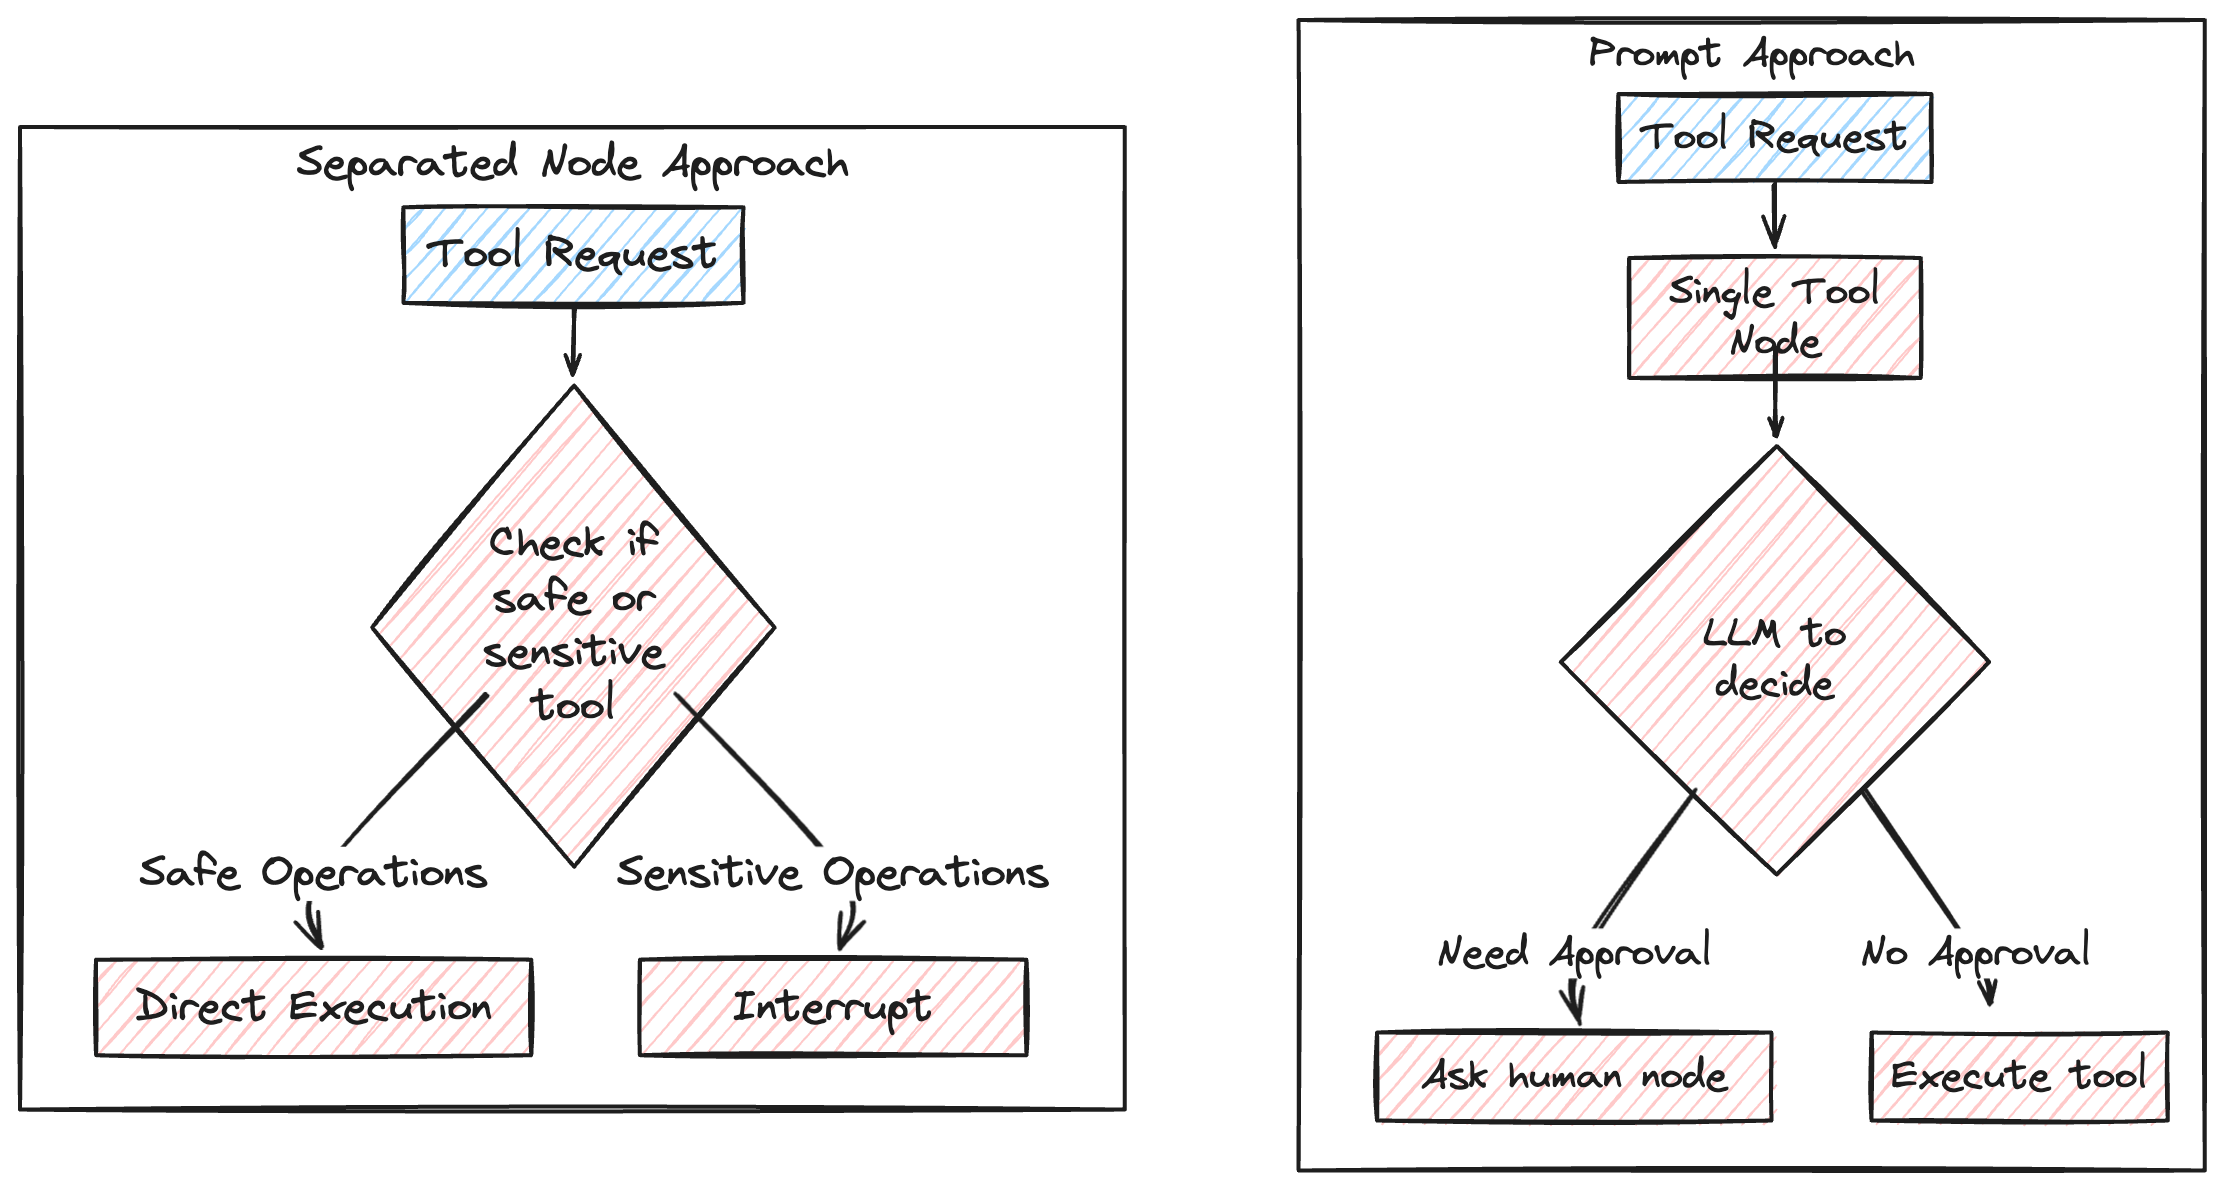

Production systems typically implement this using graph state interruption and updates based on human input, we'll use a simplified approach for demonstration purposes.

To simplify the implementation in this notebook, instead of full graph state management, we'll create a custom node that requests human approval before executing sensitive tools. This simplified approach helps demonstrate the core concepts while keeping the implementation straightforward.

<div class="alert alert-block alert-info">
<b>Note:</b> Please check the example in `DO_NOT_run` notebook to check graph state interruption example
</div>

## Custom Tool Node for Human Approval

- Custom approval node that gates access to sensitive operations
- Synchronous human input collection
- Direct tool execution after approval
- Linear workflow without complex state management

In [22]:
import json

from langchain_core.messages import ToolMessage


class HumanApprovalToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
            if user_input.lower() == "y":
                tool_result = self.tools_by_name[tool_call["name"]].invoke(
                    tool_call["args"]
                )
                outputs.append(
                    ToolMessage(
                        content=json.dumps(tool_result),
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"],
                    )
                )
            else:
                outputs.append(
                    ToolMessage(
                        content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"],
                    )
                )
        return {"messages": outputs}


## Compile the graph

We can noe compile the graph again but instead of using pre-built `ToolNode` we will use the `HumanApprovalToolNode`that we have created for human approval

In [24]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)


# Define nodes: these do the work
graph_builder.add_edge(START, "travel_planner")
graph_builder.add_node("travel_planner", call_model)
graph_builder.add_node("tools", HumanApprovalToolNode(tools=tools))

# Define edges: these determine how the control flow moves
graph_builder.add_conditional_edges(
    "travel_planner",
    tools_condition,
)

graph_builder.add_edge("tools", "travel_planner")


# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
agent_with_hil = graph_builder.compile(checkpointer=memory)

Let's take a look into a visual representation of our compiled state graph.

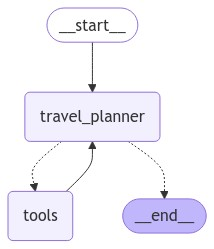

In [25]:
from IPython.display import Image, display

display(Image(agent_with_hil.get_graph().draw_mermaid_png()))

Let's test it out!

In [28]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "6", "user_id": 709}}

input_message = HumanMessage(content="Suggest me a good vacation destination.")
for event in agent_with_hil.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Suggest me a good vacation destination.
================================== Ai Message ==================================

[{'type': 'text', 'text': "Okay, let's try to find a good vacation destination for you. "}, {'type': 'tool_use', 'name': 'compare_and_recommend_destination', 'input': {'user_name': 'user'}, 'id': 'tooluse_yFH7jwdWQqa8SPq1I3qQrA'}]
Tool Calls:
  compare_and_recommend_destination (tooluse_yFH7jwdWQqa8SPq1I3qQrA)
 Call ID: tooluse_yFH7jwdWQqa8SPq1I3qQrA
  Args:
    user_name: user
================================= Tool Message =================================
Name: compare_and_recommend_destination

"No new recommendations found for users in Sacramento with similar age."
================================== Ai Message ==================================

It looks like I don't have enough information about your travel history and interests to recommend a specific destination. Could you pleas

# Congratulations

You have successfully finished this lab. You can now move over to the next one!